The goal here is to read in the HEALPix pixels for the modifed WFD footprint and create a skymap with RA, Dec labels (not doable with `healpy` so need to use the `mollweide` projection from `matplotlib`.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os
import healpy as hp
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up some things**

In [3]:
# data characteristics
nside = 256

# paths
data_dir = '/global/homes/a/awan/desc/wfd_footprint/'
filepath = '%sWFDfootprint_nside256_HEALPixels.csv'%data_dir

**First lets try creating the mollview map -- don't need to convert the HEALPix numbers to ra, dec.**

## Reading in /global/homes/a/awan/desc/wfd_footprint/WFDfootprint_nside256_HEALPixels.csv


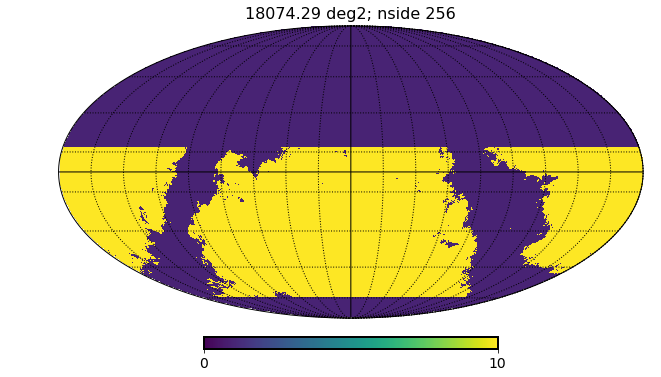

In [4]:
print('## Reading in %s'%filepath)
data = pd.read_csv(filepath)
# extract the pixel numbers
hp_pix = [int(f) for f in data['pixNum']]

# set up the skymaps
nPix = hp.nside2npix(nside)
vals = np.zeros(nPix)+1.  # initiate all data to 1
vals[hp_pix] = 5000   # add fake data to the pixels in our list

# plot the skymap
plt.clf()
hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10,
            title='%.2f deg2; nside %s'%(len(hp_pix)*hp.nside2pixarea(nside=nside, degrees=True), nside)
           )
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

**Okay, now lets create the mollweide skymap using matplotlib**

We use hp.pix2ang to get latitude, longitude corresponding to each pixel number. Then, pixel dec = np.pi/2 - latitude and ra = longitude.

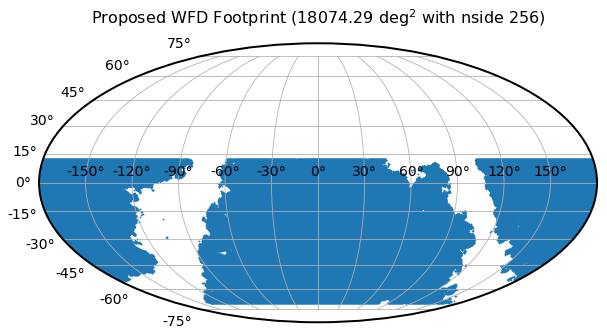

In [5]:
plt.figure()
plt.subplot(111, projection="mollweide")
# convert healpix pixels to ra, dec values
lat, ra = hp.pix2ang(ipix=hp_pix, nside=nside)
ra = np.remainder(ra+np.pi*2, np.pi*2)
dec = np.pi/2.0 - lat
c = SkyCoord(ra=ra * u.radian, dec=dec * u.radian, frame='icrs')
ra_rad = c.ra.wrap_at(180. * u.deg).radian
dec_rad = c.dec.radian

# plot the ra, dec
plt.scatter(ra_rad, dec_rad, s=0.5)
# title
plt.title(r'Proposed WFD Footprint (%.2f deg$^2$ with nside %s)'%(len(hp_pix)*hp.nside2pixarea(nside=nside,
                                                                                              degrees=True), nside),
          y=1.05)
plt.show()

Okay the RA is increasing to the right -- dont want that. Lets shift the RA values and relabel stuff.

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved WFDfootprint_nside256_matplotlib.png


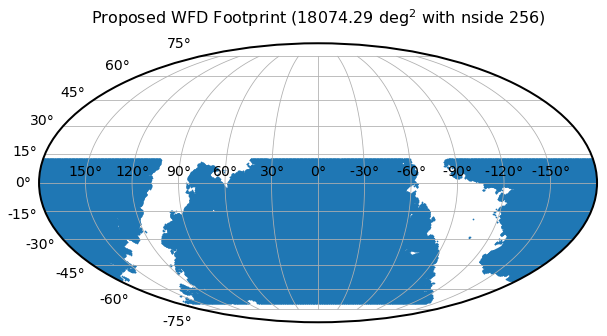

In [6]:
plt.figure()
plt.subplot(111, projection="mollweide")
# convert healpix pixels to ra, dec values
lat, ra = hp.pix2ang(ipix=hp_pix, nside=nside)
dec = np.pi/2.0 - lat
# ---------------------------------------------
# okay lets flip the ra.
ra = -ra
# ---------------------------------------------
# proceed as before
c = SkyCoord(ra=ra * u.radian, dec=dec * u.radian, frame='icrs')
ra_rad = c.ra.wrap_at(180. * u.deg).radian
dec_rad = c.dec.radian

# plot the ra, dec
plt.scatter(ra_rad, dec_rad, s=0.5)
# title
plt.title(r'Proposed WFD Footprint (%.2f deg$^2$ with nside %s)'%(len(hp_pix)*hp.nside2pixarea(nside=nside,
                                                                                              degrees=True), nside),
          y=1.05)
# ---------------------------------------------
# relabel stuff
locs, label = plt.xticks()
labels = np.rad2deg(locs)
print('Old labels: %s'%labels)
labels[labels!=0] = -labels[labels!=0]
print('News labels: %s'%labels)
labels = [r'%.f$\degree$'%(f) for f in labels]
plt.gca().set_xticklabels(labels)
# ---------------------------------------------
# save plot
filename = 'WFDfootprint_nside256_matplotlib.png'
plt.savefig(filename='%s%s'%(data_dir, filename), format='png', bbox_inches='tight')
print('\n## Saved %s'%filename)
plt.show()